In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import KS_Periodic

In [3]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'KS_Eqn_exp5'  # Prefix of data files
folder_name = 'KS_exp5h/'  # Folder to be created for saved output

In [4]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])


KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.pkl
0.020176639780402184
0.01660362258553505


In [5]:
# Create numpy arrays with data

# Use these lines to load all data
data_train = np.load(('./data/%s_train1_x.npy' % (data_name)))
#data_val = np.load(('./data/%s_val_x.npy' % data_name))

data_test1 = np.load(('./data/%s_test1_x.npy' % data_name))
data_test2 = np.load(('./data/%s_test2_x.npy' % data_name))
data_test3 = np.load(('./data/%s_test3_x.npy' % data_name))
data_test4 = np.load(('./data/%s_test4_x.npy' % data_name))
data_test5 = np.load(('./data/%s_test5_x.npy' % data_name))
data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])

In [6]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
#data_val_tensor = helperfns_convnet.stack_data(data_val, max_shifts_to_stack, params['val_len_time'])
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])
data_test1_tensor = helperfns_convnet.stack_data(data_test1, max_shifts_to_stack, params['val_len_time'])
data_test2_tensor = helperfns_convnet.stack_data(data_test2, max_shifts_to_stack, params['val_len_time'])
data_test3_tensor = helperfns_convnet.stack_data(data_test3, max_shifts_to_stack, params['val_len_time'])
data_test4_tensor = helperfns_convnet.stack_data(data_test4, max_shifts_to_stack, params['val_len_time'])
data_test5_tensor = helperfns_convnet.stack_data(data_test5, max_shifts_to_stack, params['val_len_time'])
data_test_all_tensor = helperfns_convnet.stack_data(data_test_all, max_shifts_to_stack, params['val_len_time'])

In [7]:
# Network outputs

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs:0")
    train_outputs = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
train_outputs = np.asarray(train_outputs)
test_outputs = np.asarray(test_outputs)



INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt


In [31]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-r',linewidth=2,alpha=1,zorder=2)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            #ax.plot(X[j,:],Y[j,:],Z[j,:],'-b',linewidth=2,alpha=1,zorder=2)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

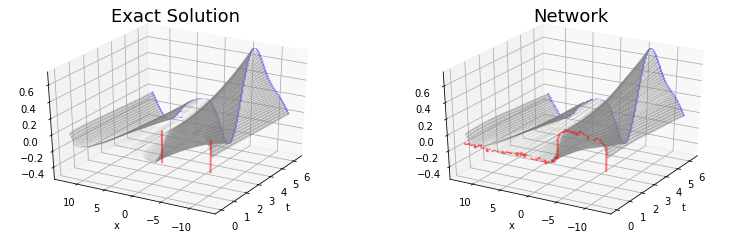

In [11]:
# Inputs
data = 'test'  # 'train', 'val', or 'test'
IC = 2013  # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_all_tensor


# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
#surf = ax.plot_surface(T, X, np.transpose(exact), cmap=plt.cm.coolwarm)
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
#surf = ax.plot_surface(T, X, np.transpose(outputs[:,IC,:]), cmap=plt.cm.coolwarm)
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

filename = '../PDEKoopmanAutoencoder/figures/KS_exp5a_testIC' + str(IC) + '.eps'
plt.show()
#plt.savefig(filename,format='eps')  

# Experiment 5 data

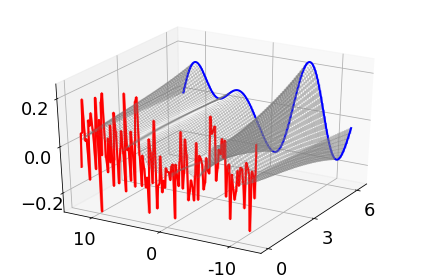

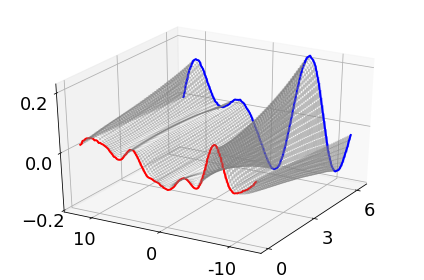

In [9]:
# Test data, IC = 1

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.2, 0, 0.2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

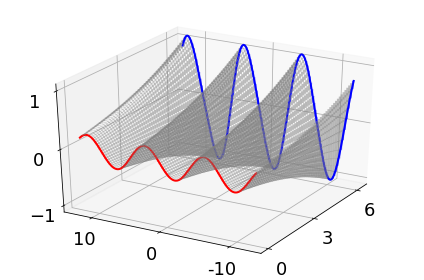

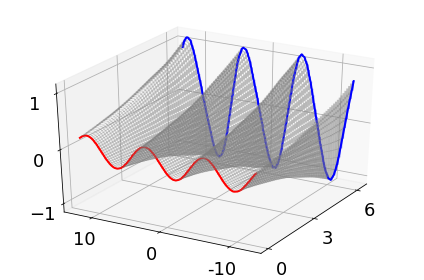

In [10]:
# Test data, IC = 1008

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1008

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

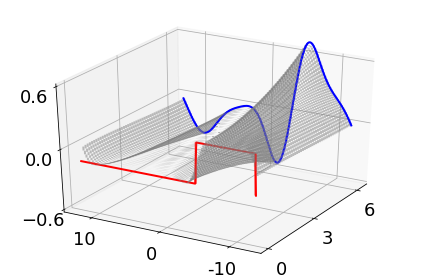

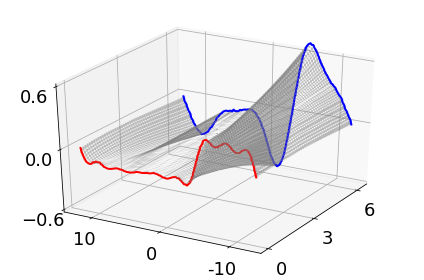

In [58]:
# Test data, IC = 2013

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2013

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

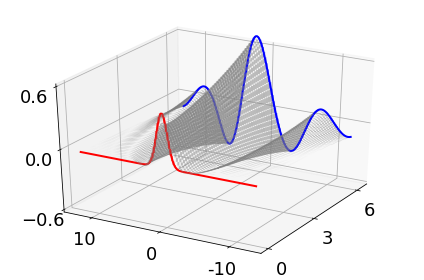

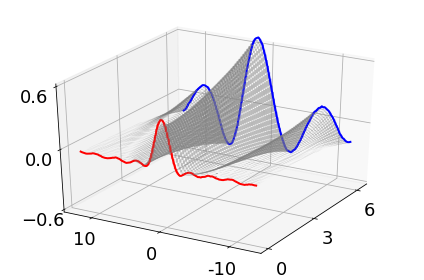

In [12]:
# Test data, IC = 3003

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3003

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

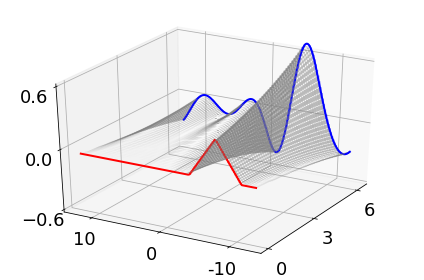

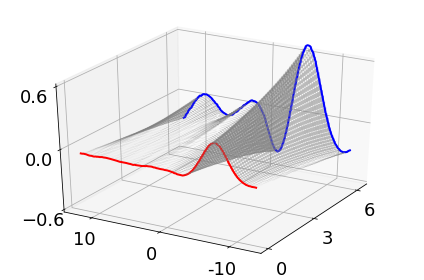

In [13]:
# Test data, IC = 4002

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4002

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zlim3d(-0.6, 0.6)  
ax.set_zticks([-0.6, 0, 0.6])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')   

# Experiment 6 data

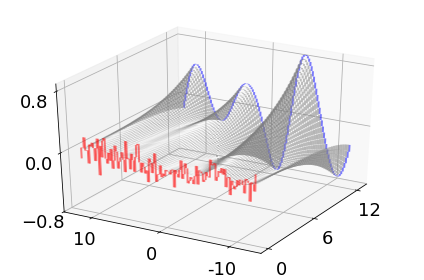

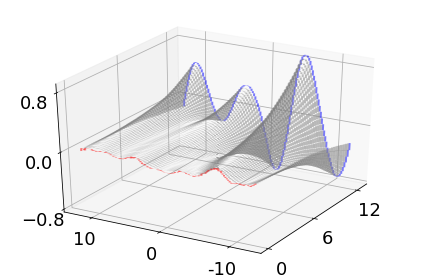

In [26]:
# Test data, IC = 1
params['delta_t'] = 0.25

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.8, 0, 0.8])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-0.8, 0, 0.8])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

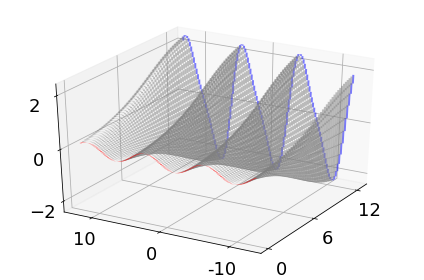

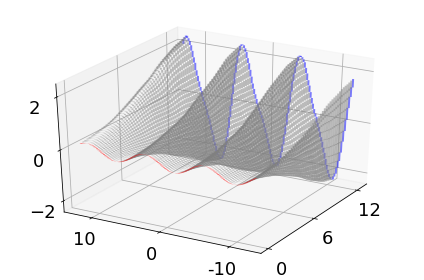

In [27]:
# Test data, IC = 1008
params['delta_t'] = 0.25

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1008

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

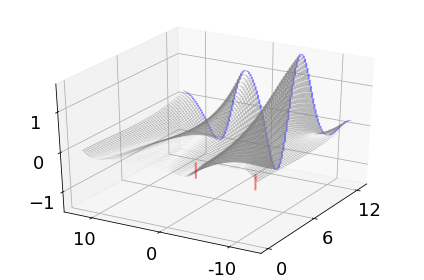

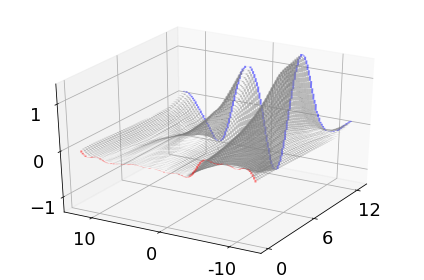

In [28]:
# Test data, IC = 2013
params['delta_t'] = 0.25

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2013

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

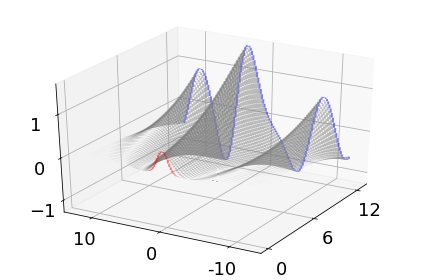

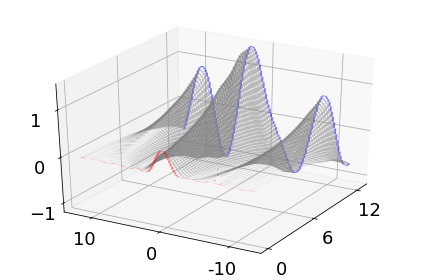

In [29]:
# Test data, IC = 3003
params['delta_t'] = 0.25

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3003

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

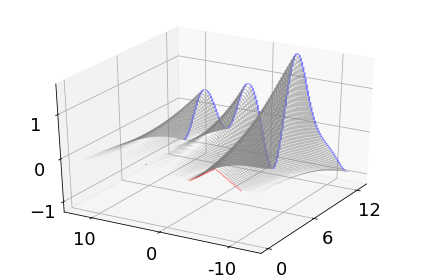

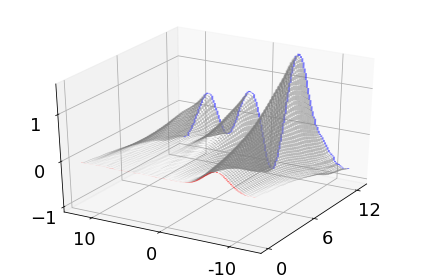

In [30]:
# Test data, IC = 4002
params['delta_t'] = 0.25

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4002

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,12.5,6), ['0','6','12'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

# Experiment 7 data

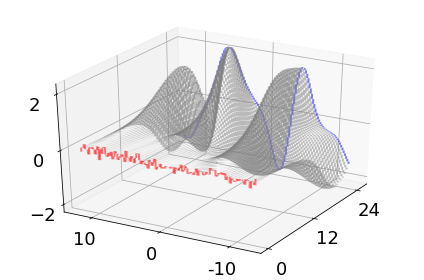

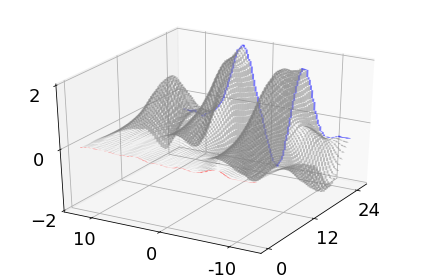

In [24]:
# Test data, IC = 1
params['delta_t'] = 0.5

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

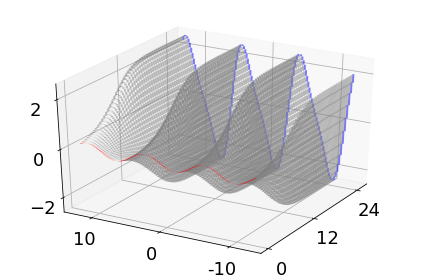

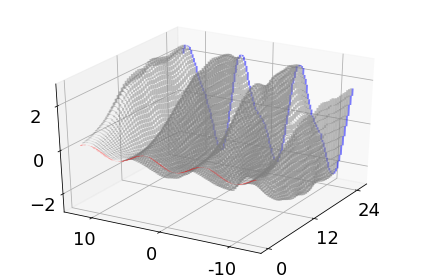

In [25]:
# Test data, IC = 1008
params['delta_t'] = 0.5

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1008

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

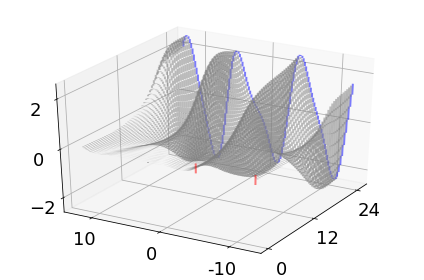

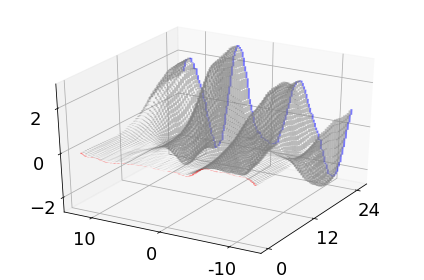

In [26]:
# Test data, IC = 2013
params['delta_t'] = 0.5

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2013

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

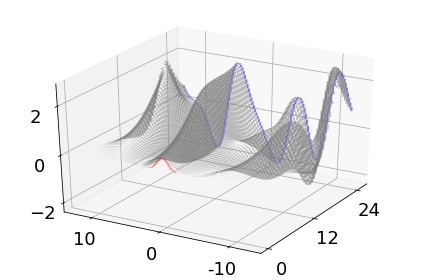

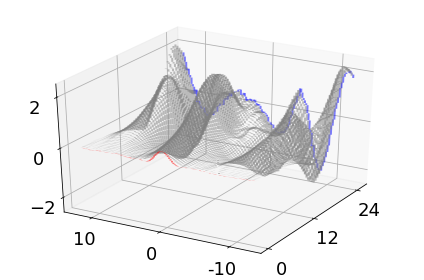

In [27]:
# Test data, IC = 3003
params['delta_t'] = 0.5

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3003

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

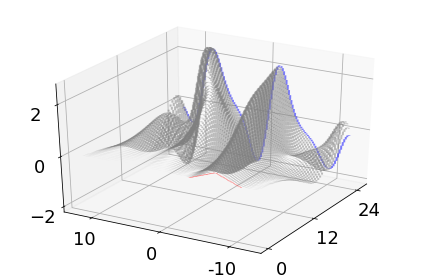

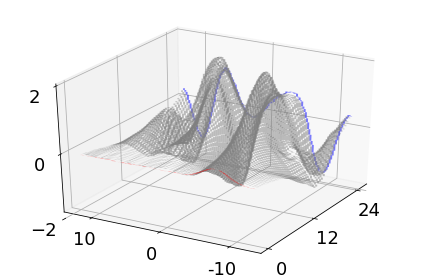

In [28]:
# Test data, IC = 4002
params['delta_t'] = 0.5

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4002

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,25,12), ['0','12','24'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

# Experiment 4 data

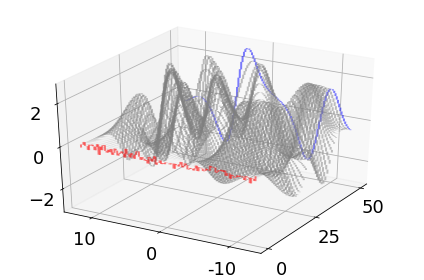

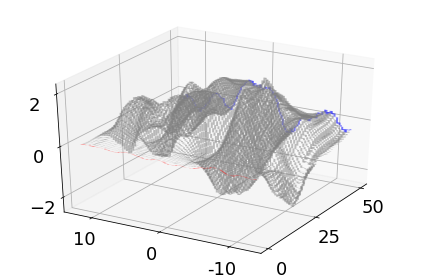

In [8]:
# Test data, IC = 1
params['delta_t'] = 1.0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

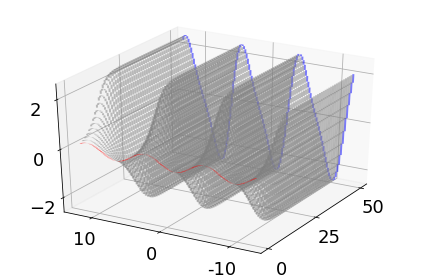

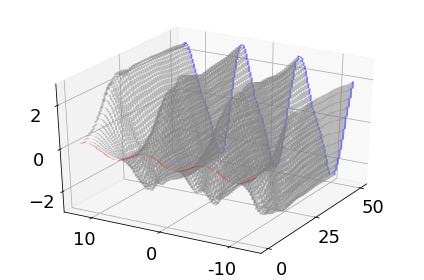

In [9]:
# Test data, IC = 1008
params['delta_t'] = 1.0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 1008

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

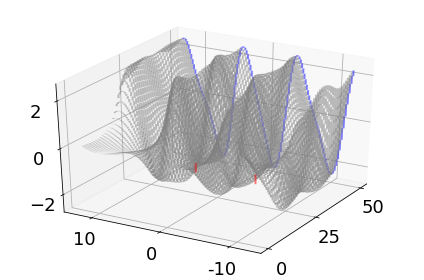

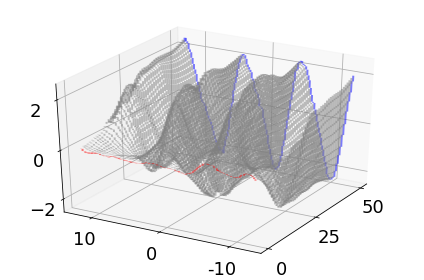

In [10]:
# Test data, IC = 2013
params['delta_t'] = 1.0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 2013

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

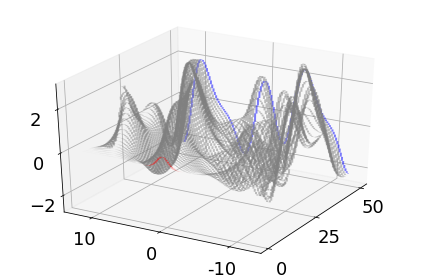

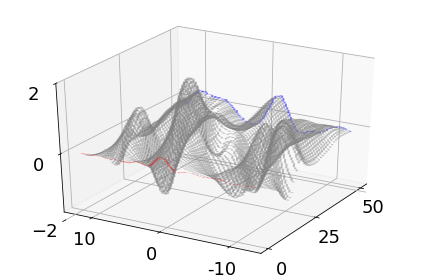

In [11]:
# Test data, IC = 3003
params['delta_t'] = 1.0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 3003

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5)
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

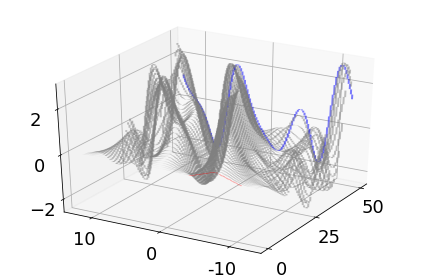

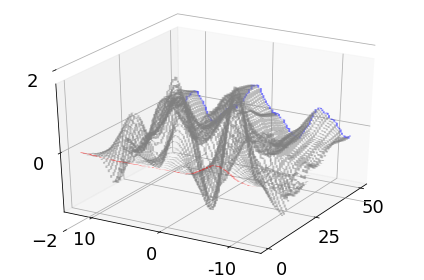

In [12]:
# Test data, IC = 4002
params['delta_t'] = 1.0

outputs = test_outputs
data_tensor = data_test_all_tensor

IC = 4002

# Exact solution (from data set)
x_pts = np.linspace(-4*np.pi,4*np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

time_in = 0
time_out = 1

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,51,25), ['0','25','50'],fontsize=18)
plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
ax.set_zticks([-2, 0, 2])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/' + params['folder_name'] + '_testIC' + str(IC) + '_network.eps'
plt.savefig(filename,format='eps')  

# Do prediction beyond 50 steps

In [17]:
# Get network outputs

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/vk_hat:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/vk_hat:0") 
    train_encoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_encoded = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})

train_encoded = np.asarray(train_encoded)
test_encoded = np.asarray(test_encoded)

INFO:tensorflow:Restoring parameters from ./KS_exp5f/KS_Eqn_exp5_2019_10_16_13_17_10_923832_model.ckpt


In [18]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
            bounds = [Z.min().min(), Z.max().max()]
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            bounds = [Z.min().min(), Z.max().max()]
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
            bounds = [Z.min().min(), Z.max().max()]
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

In [19]:
# Set parameters
L = 8*np.pi # Length of domain
dt = 0.125 # Size of time step for data
n_time = 101 # Number of time steps
t_end = dt*(n_time-1)  # End time

#Choose some initial condition
IC = 3000
u0 = data_test_all_tensor[0,IC,:]

x_pts = np.linspace(-L/2,L/2,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0,t_end,n_time)
T, X = np.meshgrid(t_pts,x_pts)

exact = KS_Periodic(x_pts,t_end,n_time,u0)  
 
# Multiply initial conditions by L_mat to move forward in time
test_encoded_pred = np.zeros((n_time,np.shape(test_encoded)[2]))

current_time = test_encoded[0,IC,:]

for n_step in xrange(n_time):
    test_encoded_pred[n_step,:] = current_time
    current_time = np.matmul(current_time,L_mat)

In [20]:
# Decode
import networkarch as net

tf.reset_default_graph()

n_middle=params['n_middle']
x = tf.placeholder(tf.float32, shape=[None, n_middle], name="x")

if params['initialization'] == 'identity':
    initialization = net.identity_initializer()
elif params['initialization'] == 'He':
    initialization = tf.contrib.layers.variance_scaling_initializer()
else: 
    raise ValueError("Error, initialization must be either identity or He")

if params['network_arch'] == 'convnet':
    y = net.decoder_apply_cn(x, n_middle=params['n_middle'], conv2_filters=params['conv2_filters'], 
                             n_outputs=params['n_outputs'], L1_lam = params['L1_lam'], L2_lam=params['L2_lam'], 
                             reuse=False, fix_middle=params['fix_middle'], seed_middle=params['seed_middle'], 
                             add_identity=params['add_identity'], initialization=initialization)
elif params['network_arch'] == 'fully_connected':
    y = net.decoder_apply_fc(x, widths=params['widths'], linear_decoder_layers=params['linear_decoder_layers'], 
                             act_type=params['act_type'], log_space=params['log_space'], L1_lam = params['L1_lam'], 
                             L2_lam=params['L2_lam'], reuse=False, fix_middle=params['fix_middle'], 
                             seed_middle=params['seed_middle'], add_identity=params['add_identity'], 
                             num_decoder_weights=params['num_decoder_weights'], initialization=initialization)
else: 
    raise ValueError("Error, network_arch must be either convnet or fully_connected")
    
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, params['model_path'])
    
    inputs = test_encoded_pred
    decoded_list = sess.run(y, feed_dict={"x:0": inputs})
    decoded_list = np.asarray(decoded_list)

INFO:tensorflow:Restoring parameters from ./KS_exp5f/KS_Eqn_exp5_2019_10_16_13_17_10_923832_model.ckpt


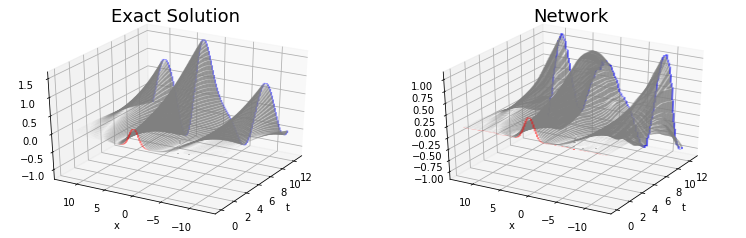

In [21]:
fig = plt.figure(figsize=(13,4)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=n_time-1,linewidth=2,alpha=.5) 
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(decoded_list),time_in=0,time_out=n_time-1,linewidth=2,alpha=.5) 
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize=18)

plt.show() 

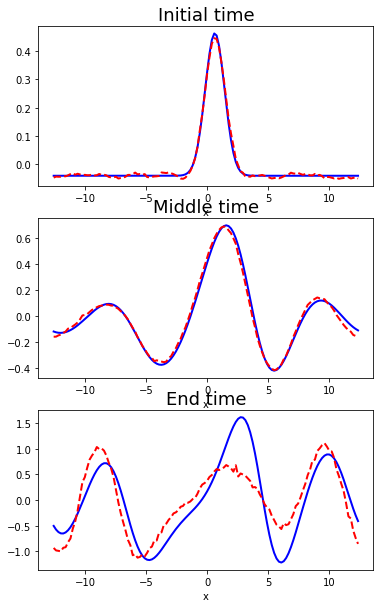

In [22]:
fig = plt.figure(figsize=(6,10)) 

ax = fig.add_subplot(3, 1, 1)
ax.plot(x_pts,exact[0,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[0,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('Initial time', fontsize=18)

ax = fig.add_subplot(3, 1, 2)
ax.plot(x_pts,exact[50,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[50,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('Middle time', fontsize=18)

ax = fig.add_subplot(3, 1, 3)
ax.plot(x_pts,exact[-1,:],'-b',linewidth=2) 
ax.plot(x_pts,decoded_list[-1,:],'--r',linewidth=2) 
ax.set_xlabel('x')
ax.set_title('End time', fontsize=18)

plt.show() 

# Check different losses

In [23]:
# Check how much of each loss comes from each type (test data)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    loss1 = sess.run("loss1:0", feed_dict={"x:0": data_test_all_tensor})
    loss2 = sess.run("loss2:0", feed_dict={"x:0": data_test_all_tensor})
    loss3 = sess.run("loss3:0", feed_dict={"x:0": data_test_all_tensor})
    loss4 = sess.run("loss4:0", feed_dict={"x:0": data_test_all_tensor})
    loss5 = sess.run("loss5:0", feed_dict={"x:0": data_test_all_tensor})
            
print(loss1)
print(loss2)
print(loss3)
print(loss4)
print(loss5)

INFO:tensorflow:Restoring parameters from ./KS_exp5f/KS_Eqn_exp5_2019_10_16_13_17_10_923832_model.ckpt
0.0022746946
0.0047629476
0.0046105376
0.0005637597
0.0009013343


# Plot (partially) encoded

In [24]:
# Get partially encoded 
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Partially  Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/v_k:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/v_k:0") 
    train_partiallyencoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_partiallyencoded = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})
    
train_partiallyencoded = np.asarray(train_partiallyencoded)
test_partiallyencoded = np.asarray(test_partiallyencoded)

INFO:tensorflow:Restoring parameters from ./KS_exp5f/KS_Eqn_exp5_2019_10_16_13_17_10_923832_model.ckpt


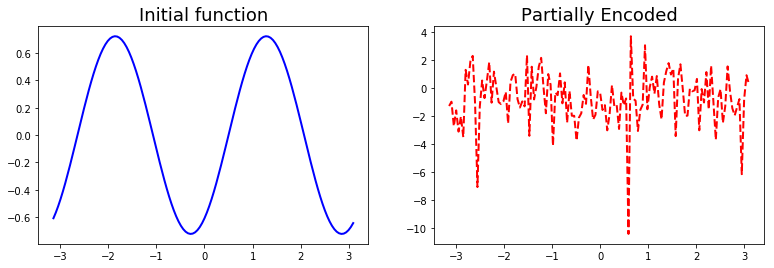

In [29]:
# Plot partially encoded

# Inputs
data = 'test'  # 'train', 'val', or 'test'
ind = 1000    # index of initial condition

if data == 'train':
    partially_encoded = train_partiallyencoded
    data_tensor = data_train_tensor
elif data == 'val':
    partially_encoded = val_partiallyencoded
    data_tensor = data_val_tensor
else:
    partially_encoded = test_partiallyencoded
    data_tensor = data_test_all_tensor

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]  
    

f, (ax1, ax2) = plt.subplots(1,2,figsize=(13,4))
ax1.plot(x_pts, data_tensor[0,ind,:], "b-", linewidth=2)
ax1.set_title('Initial function', fontsize=18)
ax2.plot(x_pts, partially_encoded[0,ind,:], "r--", linewidth=2)
ax2.set_title('Partially Encoded', fontsize=18)
filename = '../PDEKoopmanAutoencoder/figures/KS_exp5e_PE_testIC' + str(ind) + '.svg'
plt.show() 

# Plot eigenvalues and eigenfunctions

In [17]:
# Get all the needed things from the network
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    
    # Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/vk_hat:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/vk_hat:0") 
    train_encoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    test_encoded = sess.run(tensor_list, feed_dict={"x:0": data_test_all_tensor})

train_encoded = np.asarray(train_encoded)
test_encoded = np.asarray(test_encoded)

INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt


In [18]:
lam, V = np.linalg.eig(L_mat)
lam = np.log(lam)
ind = np.argsort(lam)
ind = np.flip(ind,0)
lam = np.sort(lam)
lam = np.flip(lam,0)
network_lam = lam/params['delta_t']
print(params['delta_t'])
print(lam/params['delta_t'])

0.125
[ 2.2706877e-01+0.00128215j  2.2706877e-01-0.00128215j
  1.7175464e-01+0.j          1.6101220e-01+0.j
  6.1554007e-02+0.j          2.8584849e-02+0.j
 -2.1823044e-03+0.j         -1.2761753e-02+0.j
 -8.6908543e-01+0.j         -8.7872410e-01+0.j
 -1.6597000e+00+0.j         -2.8095505e+00+0.03046541j
 -2.8095505e+00-0.03046541j -3.6686523e+00+0.5394154j
 -3.6686523e+00-0.5394154j  -5.2112918e+00+0.j
 -6.3906646e+00+0.1585457j  -6.3906646e+00-0.1585457j
 -6.4006300e+00+0.j         -1.1676833e+01+0.j
 -1.1853354e+01+0.j        ]


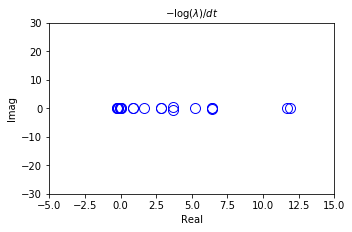

In [21]:
plt.figure(figsize=(5,3.33))
plt.plot(-np.real(network_lam),np.imag(network_lam),'ob',markersize=10,markerfacecolor="None")
plt.ylim(-30,30)
plt.xlim(-5,15)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.title('$-\log(\lambda)/dt$',fontsize=10)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.tight_layout()
plt.show()

In [22]:
# Decoder
import networkarch as net

tf.reset_default_graph()

n_middle=params['n_middle']
x = tf.placeholder(tf.float32, shape=[None, n_middle], name="x")

if params['initialization'] == 'identity':
    initialization = net.identity_initializer()
elif params['initialization'] == 'He':
    initialization = tf.contrib.layers.variance_scaling_initializer()
else: 
    raise ValueError("Error, initialization must be either identity or He")

if params['network_arch'] == 'convnet':
    y = net.decoder_apply_cn(x, n_middle=params['n_middle'], conv2_filters=params['conv2_filters'], 
                             n_outputs=params['n_outputs'], L1_lam = params['L1_lam'], L2_lam=params['L2_lam'], 
                             reuse=False, fix_middle=params['fix_middle'], seed_middle=params['seed_middle'], 
                             add_identity=params['add_identity'], initialization=initialization)
elif params['network_arch'] == 'fully_connected':
    y = net.decoder_apply_fc(x, widths=params['widths'], linear_decoder_layers=params['linear_decoder_layers'], 
                             act_type=params['act_type'], log_space=params['log_space'], L1_lam = params['L1_lam'], 
                             L2_lam=params['L2_lam'], reuse=False, fix_middle=params['fix_middle'], 
                             seed_middle=params['seed_middle'], add_identity=params['add_identity'], 
                             num_decoder_weights=params['num_decoder_weights'], initialization=initialization)
else: 
    raise ValueError("Error, network_arch must be either convnet or fully_connected")
    
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, params['model_path'])
    
    inputs = V.T
    decoded_list = sess.run(y, feed_dict={"x:0": inputs})
    decoded_list = np.asarray(decoded_list)

INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt


/anaconda3/envs/tensorflow/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


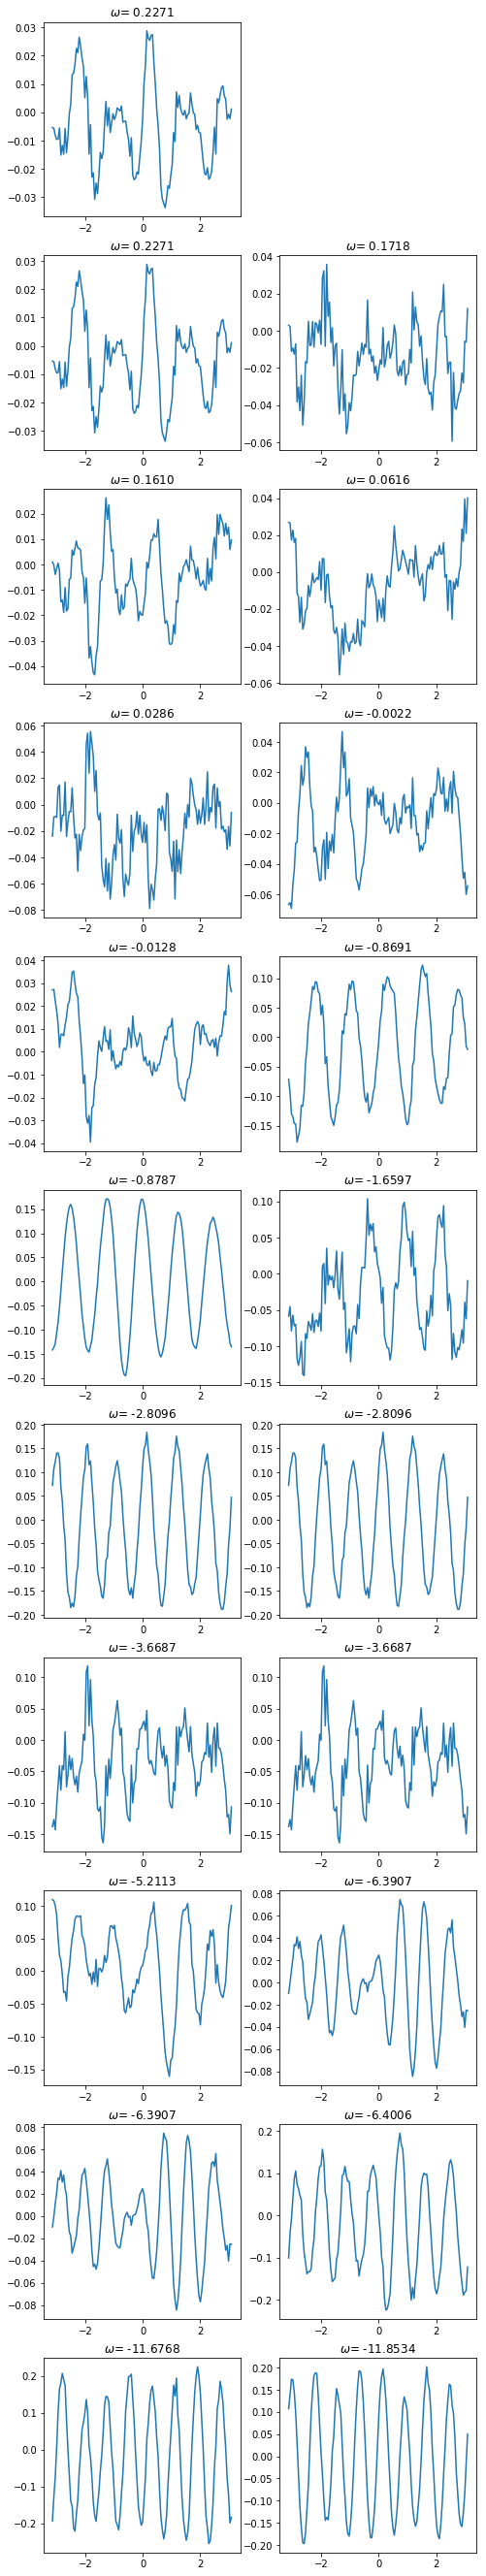

In [23]:
# Plot eigenvectors
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = decoded_list
f = np.real(f)

scale = np.zeros((21))
fig = plt.figure(figsize=(8,48)) 

ax = fig.add_subplot(11, 2, 1)
ax.plot(x_pts,f[ind[0],:])
ax.title.set_text('$\omega$= %6.4f' % network_lam[0])
scale[0] = np.linalg.norm(f[ind[0]])

for k in np.arange(10):
    ax = fig.add_subplot(11, 2, 2*k+3)
    ax.plot(x_pts,f[ind[2*k+1],:])
    ax.title.set_text('$\omega$= %6.4f' % network_lam[2*k+1])
    scale[2*k+1] = np.linalg.norm(f[ind[2*k+1],:])
    
    ax = fig.add_subplot(11, 2, 2*k+4)
    ax.plot(x_pts,f[ind[2*k+2],:])
    ax.title.set_text('$\omega$= %6.4f' % network_lam[2*k+2])
    scale[2*k+2] = np.linalg.norm(f[ind[2*k+2],:])
plt.show()

# Plot (test) prediction loss vs time step

In [4]:
import helperfns

# Best full width networks
folder_name_list = ['KS_exp5f/','KS_exp6i/','KS_exp7g/','KS_exp4f/']

full_width_predloss = np.zeros(4)
for ind in range(4):
    folder_name = folder_name_list[ind]
    pkl_file = folder_name + BestErrorFile(folder_name)

    with open(pkl_file, 'rb') as f:
         params = pickle.load(f)
    
    data_name = params['data_name'] 
    data_test1 = np.load(('./data/%s_test1_x.npy' % data_name))
    data_test2 = np.load(('./data/%s_test2_x.npy' % data_name))
    data_test3 = np.load(('./data/%s_test3_x.npy' % data_name))
    data_test4 = np.load(('./data/%s_test4_x.npy' % data_name))
    data_test5 = np.load(('./data/%s_test5_x.npy' % data_name))
    data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])
    
    max_shifts_to_stack = helperfns.num_shifts_in_stack(params)
    data_test_all_tensor = helperfns.stack_data(data_test_all, max_shifts_to_stack, params['val_len_time'])
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        pred_loss = sess.run("loss2:0", feed_dict={"x:0": data_test_all_tensor})
        print(pred_loss)
        full_width_predloss[ind] = pred_loss
    

INFO:tensorflow:Restoring parameters from ./KS_exp5f/KS_Eqn_exp5_2019_10_16_13_17_10_923832_model.ckpt
0.0047629476
INFO:tensorflow:Restoring parameters from ./KS_exp6i/KS_Eqn_exp6_2019_10_19_20_18_32_846738_model.ckpt
0.024210492
INFO:tensorflow:Restoring parameters from ./KS_exp7g/KS_Eqn_exp7_2019_10_21_07_37_53_340646_model.ckpt
0.14672409
INFO:tensorflow:Restoring parameters from ./KS_exp4f/KS_Eqn_exp4_2019_10_23_18_52_14_520335_model.ckpt
0.4687274


In [5]:
# Best reduced width networks
folder_name_list = ['KS_exp5h/','KS_exp6j/','KS_exp7h/','KS_exp4e/']

reduced_width_predloss = np.zeros(4)
for ind in range(4):
    folder_name = folder_name_list[ind]
    pkl_file = folder_name + BestErrorFile(folder_name)

    with open(pkl_file, 'rb') as f:
         params = pickle.load(f)
            
    data_name = params['data_name']  
    data_test1 = np.load(('./data/%s_test1_x.npy' % data_name))
    data_test2 = np.load(('./data/%s_test2_x.npy' % data_name))
    data_test3 = np.load(('./data/%s_test3_x.npy' % data_name))
    data_test4 = np.load(('./data/%s_test4_x.npy' % data_name))
    data_test5 = np.load(('./data/%s_test5_x.npy' % data_name))
    data_test_all = np.vstack([data_test1,data_test2,data_test3,data_test4,data_test5])
    
    max_shifts_to_stack = helperfns.num_shifts_in_stack(params)
    data_test_all_tensor = helperfns.stack_data(data_test_all, max_shifts_to_stack, params['val_len_time'])    
    
    tf.reset_default_graph()

    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(params['model_path']+'.meta')
        saver.restore(sess, params['model_path'])
    
        pred_loss = sess.run("loss2:0", feed_dict={"x:0": data_test_all_tensor})
        print(pred_loss)
        reduced_width_predloss[ind] = pred_loss

INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt
0.008977019
INFO:tensorflow:Restoring parameters from ./KS_exp6j/KS_Eqn_exp6_2019_10_19_20_13_17_886212_model.ckpt
0.022841832
INFO:tensorflow:Restoring parameters from ./KS_exp7h/KS_Eqn_exp7_2019_10_21_16_25_05_027698_model.ckpt
0.119972944
INFO:tensorflow:Restoring parameters from ./KS_exp4e/KS_Eqn_exp4_2019_10_22_18_18_45_259709_model.ckpt
0.46454412


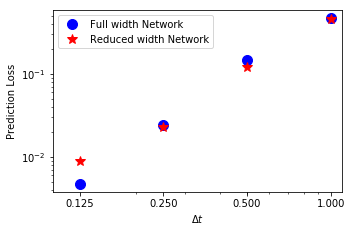

In [6]:
dt_array = np.array([0.125, 0.25,0.5,1])

plt.figure(figsize=(5,3.33))
Full, = plt.plot(dt_array,full_width_predloss,'ob',markersize=10)
Reduced, = plt.plot(dt_array,reduced_width_predloss,'*r',markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.xticks([0.125,0.25,0.5,1.0,2])
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlim(0.1,1.1)
plt.xlabel('$\Delta t$')
plt.ylabel('Prediction Loss')
plt.legend([Full,Reduced],['Full width Network','Reduced width Network'],fontsize=10)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/KS_predloss_vs_dt.eps'
plt.savefig(filename,format='eps')  

In [22]:
print(full_width_predloss)
print(reduced_width_predloss)

[0.00476295 0.02421049 0.14672409 0.83816457]
[0.00897702 0.02284183 0.11997294 0.42936301]


# Homotopy vs From scratch

# Good results above, testing below


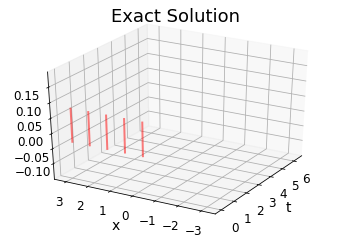

In [56]:


# Inputs
data = 'test'  # 'train', 'val', or 'test'
IC = 2001  # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_all_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

Z = np.transpose(exact)
# T->X
# X->Y
# np.transpose(exact)->Z

fig = plt.figure(figsize=(13,4)) 
ax = fig.add_subplot(1, 2, 1, projection='3d')
j = 0
norm = plt.Normalize(Z.min().min(), Z.max().max())
n,m = Z.shape
if n>m:
    T=T.T; X=X.T; Z=Z.T
    m,n = n,m

points = np.array([T[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

cmap = matplotlib.colors.ListedColormap(['red'])
bounds = [Z.min().min(), Z.max().max()]
lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, linewidth=2,alpha=.5)
line = ax.add_collection3d(lc,zs=(X[j,1:]+X[j,:-1])/2, zdir='y') # add line to axes
ax.auto_scale_xyz(T,X,Z)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize=18)
plt.show()


In [10]:
points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

(128, 51)


In [57]:
print(points.shape)
print(points[:,0,0])
print(points[:,0,1])

(128, 1, 2)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938 -0.03233938
 -0.03233938 

In [13]:
print(Z[0,:])

[-0.03978873 -0.03978869 -0.0397785  -0.03979819 -0.03991408 -0.03994906
 -0.03978778 -0.03944194 -0.03898578 -0.03850448 -0.03807095 -0.0377396
 -0.03754742 -0.03751742 -0.03766228 -0.03798743 -0.03849348 -0.03917799
 -0.04003671 -0.04106447 -0.04225574 -0.0436051  -0.04510736 -0.04675786
 -0.04855243 -0.05048752 -0.05256014 -0.05476791 -0.05710901 -0.05958217
 -0.0621866  -0.06492203 -0.06778861 -0.07078692 -0.07391793 -0.07718298
 -0.08058374 -0.08412221 -0.08780068 -0.09162172 -0.09558817 -0.09970311
 -0.10396986 -0.10839195 -0.11297313 -0.11771733 -0.12262869 -0.12771149
 -0.1329702  -0.13840945 -0.14403398]


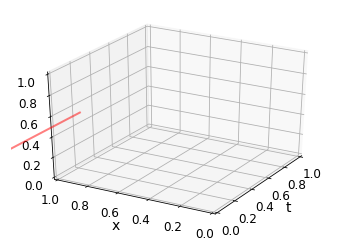

In [45]:
fig = plt.figure(figsize=(13,4)) 
ax = fig.add_subplot(1, 2, 1, projection='3d')

Z = np.array([0,1,0])
X = np.array([0,0,0])
Y = np.array([0,1,2])
points = np.array([[0,0,0],[0,1,0]]).reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1) 

cmap = matplotlib.colors.ListedColormap(['red'])
bounds = [Z.min().min(), Z.max().max()]
lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[1:]+Z[:-1])/2, linewidth=2,alpha=.5)
line = ax.add_collection3d(lc,zs=(Y[1:]+Y[:-1])/2, zdir='y') # add line to axes
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
plt.show()

In [31]:
points = np.array([[0,0,0],[0,1,0]]).reshape(-1, 1, 2)
print(points.shape)
print(points)

(3, 1, 2)
[[[0 0]]

 [[0 0]]

 [[1 0]]]


In [5]:
data_train = data_test_all

In [14]:
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    pred_loss = sess.run("loss2:0", feed_dict={"x:0": data_test_all_tensor})
    print(pred_loss)

INFO:tensorflow:Restoring parameters from ./KS_exp5h/KS_Eqn_exp5_2019_10_18_07_18_03_991009_model.ckpt
0.008977019


In [34]:
print(np.shape(exact))

(51, 128)


In [35]:
print(exact[0,:]) # indices 1 to 42

[-0.12997186  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286  0.26613286
  0.26613286 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0.12997186
 -0.12997186 -0.12997186 -0.12997186 -0.12997186 -0